# LSTM을 이용한 주가 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense, Lambda

- Apple 주식 가격 예측

In [2]:
aapl = yf.download('AAPL', start='2019-01-01', end='2022-12-31', progress=False)
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.893322,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.118877,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.575382,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.496201,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.172874,164101200


<Axes: xlabel='Date'>

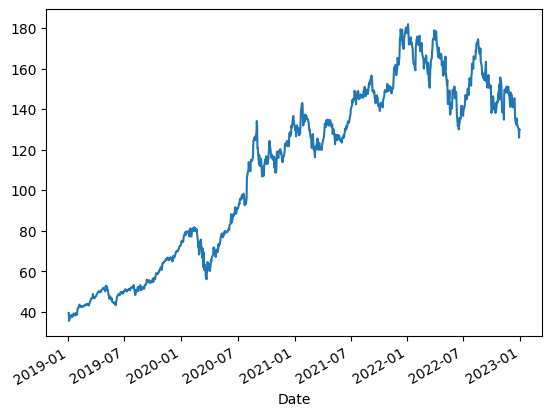

In [3]:
aapl.Close.plot()

LSTM layer로 하려고 하는 것은 지난 window-size 일(즉, t-window에서 t-1까지)의 역사적 가격을 사용하여 시간 t의 가격을 예측하는 것입니다. 정확한 가격이 아닌 추세를 파악하기 위해 노력할 것임을 명심하십시오.

- training dataset 생성

In [4]:
aapl.shape

(1008, 6)

In [5]:
# 주식 종가 데이터를 사용하여 과거 데이터의 시퀀스와 다음 시점의 종가를 예측하기 위한 데이터셋을 생성하는 코드

hist = []  # 과거 데이터 시퀀스를 저장할 리스트
target = []  # 각 시퀀스 다음에 오는 타겟 종가를 저장할 리스트

# 윈도우 크기 설정
window = 3

# 'Close' 컬럼에서 종가 데이터를 numpy 배열로 가져옵니다.
close = aapl['Close'].values

# 윈도우 크기만큼의 데이터 시퀀스와 그 다음 시점의 종가를 hist와 target 리스트에 추가합니다.
for i in range(len(close) - window):
    x = close[i:i+window]   # 현재 인덱스부터 윈도우 크기만큼의 데이터를 선택
    y = close[i+window]     # 현재 시퀀스 다음의 종가를 선택
    hist.append(x)          # 선택된 데이터 시퀀스를 hist 리스트에 추가
    target.append(y)        # 선택된 타겟 종가를 target 리스트에 추가

In [6]:
close[:10]

array([39.47999954, 35.54750061, 37.06499863, 36.98249817, 37.6875    ,
       38.32749939, 38.45000076, 38.07249832, 37.5       , 38.26750183])

In [7]:
hist[:5]

[array([39.47999954, 35.54750061, 37.06499863]),
 array([35.54750061, 37.06499863, 36.98249817]),
 array([37.06499863, 36.98249817, 37.6875    ]),
 array([36.98249817, 37.6875    , 38.32749939]),
 array([37.6875    , 38.32749939, 38.45000076])]

In [8]:
target[:5]

[36.98249816894531,
 37.6875,
 38.32749938964844,
 38.45000076293945,
 38.0724983215332]

확인 방법 

- "hist"의 각 요소는 window개 timestep의 list입니다. 1씩 증가하기 때문에 "hist"의 두 번째 요소의 마지막 항목은 "target"의 첫 번째 요소와 같아야 합니다. 또한 마지막 숫자가 같아야 합니다.

```
print(close[-1])
print(i+length)
print(target[-1])
```

In [9]:
# hist 리스트의 두 번째 요소의 마지막 값과 target 리스트의 첫 번째 요소를 비교합니다.
# hist 리스트는 주어진 창 (window) 크기로 추출된 연속적인 일련의 주가 데이터를 포함하고 있으며,
# target 리스트는 해당 창 다음의 주가 값을 포함하고 있습니다.
hist[1][-1] == target[0]

True

In [10]:
# hist 리스트와 target 리스트를 NumPy 배열로 변환
hist = np.array(hist)
target = np.array(target)

# target 배열의 형태를 (-1, 1)로 재구성합니다.
target = target.reshape(-1, 1)

# 변환된 배열의 형태(shape)를 출력
print(hist.shape)    
print(target.shape)

(1005, 3)
(1005, 1)


In [11]:
len(hist) - 100

905

1098일의 데이터로 모델을 학습시키고 다음 100일의 데이터로 테스트하는 방식으로 데이터를 분할합니다.

In [12]:
#train/test split
split = len(hist) - 100
X_train = hist[:split]
X_test = hist[split:]
y_train = target[:split]
y_test = target[split:]

In [13]:
X_train = X_train.reshape(-1, window, 1)
X_tes = X_test.reshape(-1, window, 1)

X_train.shape, X_test.shape

((905, 3, 1), (100, 3))

- model 생성 및 fitting

In [14]:
model = tf.keras.Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(window, 1), dropout=0.2))
model.add(LSTM(units=32, return_sequences=True, dropout=0.2))
model.add(LSTM(units=16, dropout=0.2))
model.add(Dense(units=1))
model.add(Lambda(lambda x: x * 100))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 32465 (126.82 KB)
Trainable params: 32465 (126.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
29/29 [==============================] - 3s 4ms/step - loss: 6262.5513
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 1996.6943
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 692.4270
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 283.1309
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 214.7096
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 194.7484
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 165.1873
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 151.0805
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 148.6753
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 117.7155
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 104.0220
Epoch 12/100
29/29 [==============================] - 0s 4ms/step - loss: 97.9201
Epoch 13/100

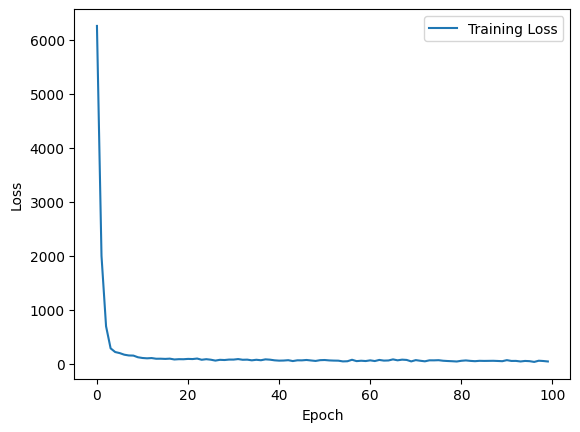

In [17]:
plt.plot(history.history['loss'])
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

앞으로 100일 동안의 주가 추이를 예측해 보도록 하겠습니다. 우리의 목표는 실제 가격이 아니라 추세를 예측하는 것임을 기억하십시오.

4/4 [==============================] - 1s 3ms/step


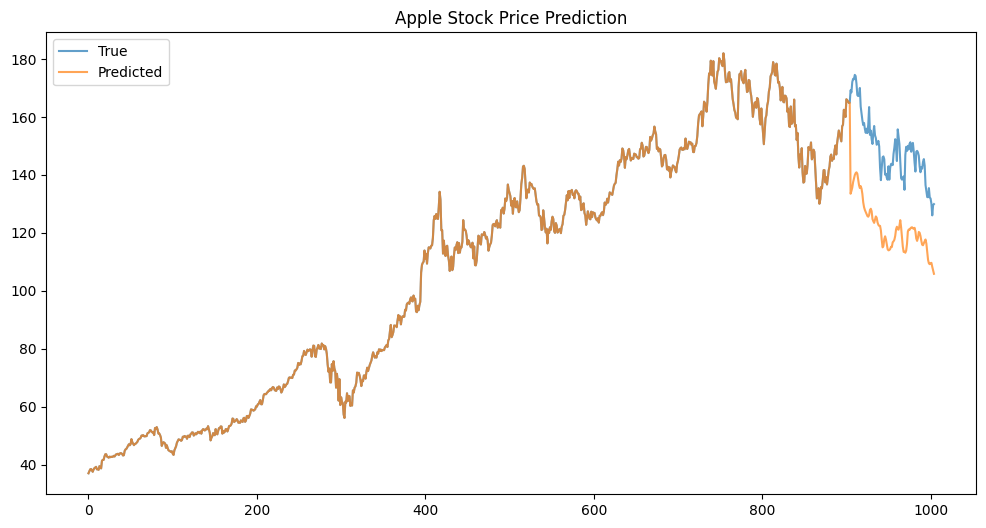

In [18]:
# 모델을 사용하여 테스트 데이터에 대한 예측값 계산
pred = model.predict(X_test)

plt.figure(figsize=(12,6))

# 실제 주가와 예측 주가를 연결하여 그래프로 그립니다.
plt.plot(np.concatenate((y_train, y_test)), label='True', alpha=0.7)  # 실제 주가
plt.plot(np.concatenate((y_train, pred)), label='Predicted', alpha=0.7)  # 예측 주가

plt.title('Apple Stock Price Prediction')
plt.legend()
plt.show()

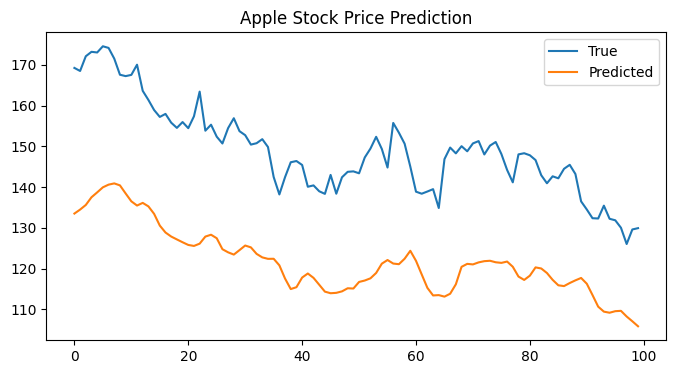

In [19]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label='True')
plt.plot(pred, label='Predicted')
plt.title('Apple Stock Price Prediction')
plt.legend()
plt.show()

## 다양한 window_size tuning 을 하여 보다 정확한 예측 시도